## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools

import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [16, 32, 128, 256]
MOMENTUM = 0.95

In [9]:
results={}
"""
撰寫訓練流程並將結果用 dictionary 紀錄
"""
for bs in BATCH_SIZE:        
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch_size = %d" % (bs))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)         

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = "exp-bs-%s" % (str(bs))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Batch_size = 16
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batc

Epoch 16/20
50000/50000 [==============================] - 10s 200us/step - loss: 1.1503 - accuracy: 0.5939 - val_loss: 1.4210 - val_accuracy: 0.5023
Epoch 17/20
50000/50000 [==============================] - 10s 199us/step - loss: 1.1262 - accuracy: 0.6000 - val_loss: 1.4334 - val_accuracy: 0.5037
Epoch 18/20
50000/50000 [==============================] - 10s 204us/step - loss: 1.1038 - accuracy: 0.6091 - val_loss: 1.4656 - val_accuracy: 0.4897
Epoch 19/20
50000/50000 [==============================] - 11s 213us/step - loss: 1.0877 - accuracy: 0.6143 - val_loss: 1.4288 - val_accuracy: 0.4998
Epoch 20/20
50000/50000 [==============================] - 11s 218us/step - loss: 1.0801 - accuracy: 0.6151 - val_loss: 1.4311 - val_accuracy: 0.5063
Experiment with Batch_size = 128
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
__

50000/50000 [==============================] - 3s 62us/step - loss: 1.0582 - accuracy: 0.6312 - val_loss: 1.5091 - val_accuracy: 0.4822
Epoch 12/20
50000/50000 [==============================] - 3s 59us/step - loss: 1.0200 - accuracy: 0.6454 - val_loss: 1.4821 - val_accuracy: 0.4889
Epoch 13/20
50000/50000 [==============================] - 3s 64us/step - loss: 0.9895 - accuracy: 0.6569 - val_loss: 1.5328 - val_accuracy: 0.4763
Epoch 14/20
50000/50000 [==============================] - 3s 66us/step - loss: 0.9484 - accuracy: 0.6713 - val_loss: 1.6269 - val_accuracy: 0.4601
Epoch 15/20
50000/50000 [==============================] - 3s 67us/step - loss: 0.9161 - accuracy: 0.6822 - val_loss: 1.5672 - val_accuracy: 0.4751
Epoch 16/20
50000/50000 [==============================] - 4s 73us/step - loss: 0.8843 - accuracy: 0.6947 - val_loss: 1.5699 - val_accuracy: 0.4810
Epoch 17/20
50000/50000 [==============================] - 3s 67us/step - loss: 0.8491 - accuracy: 0.7088 - val_loss: 1.6519

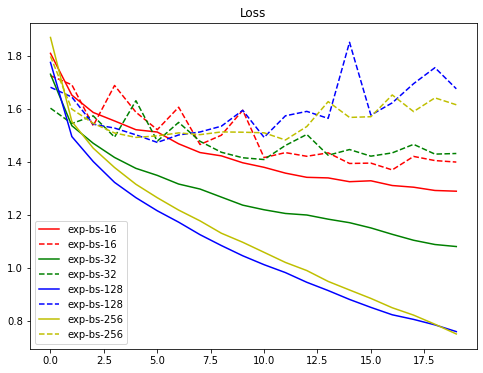

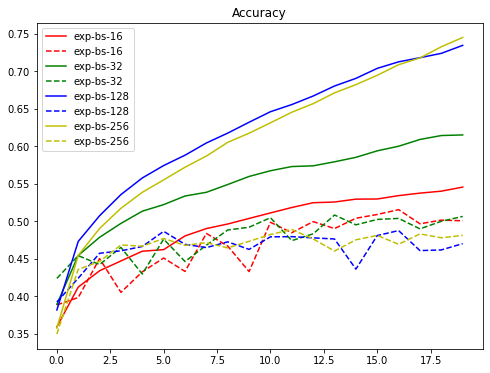

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

參考資源:
1. https://morvanzhou.github.io/tutorials/machine-learning/ML-intro/3-08-batch-normalization/
2. https://zhuanlan.zhihu.com/p/34879333